The repository contains the following packages: config, data, models

__1-__ The __config__ package contains configs of the models and also settings of the project.


__2-__ The __data__ package stores and loads the data needed for the models. It has datasets and data_loaders sub-packages.
The datasets sub-package stores raw data samples; one of our used datasets is CAVE which you can find its full data here: https://www1.cs.columbia.edu/CAVE/databases/multispectral/

In data_loader sub-package, we prepare data samples needed for the models. In reformat_cave_data.py file, we change the CAVE data format to use them for our models. Also, in simulate_data.py we select some random patches from both RGB and HS images to train our models and then simulate functionality of the spectrophotometer.


__3-__ The __models__ package contains our implemented models. At regression.py file, we have implemented a regression model to reconstruct HS images from the corresponding RGB images.


We evaluate our models by using RMSE and delta_e 2000.

At the first we should load the data and select some random patches to train the model. The number of patches and their sizes are:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from config import PATCHES_NUM, PATCHES_SIZE

patches_num = PATCHES_NUM
patches_size = PATCHES_SIZE
print('patches_num: ',patches_num, ', patches_size: ', patches_size)

patches_num:  200 , patches_size:  10


At load_data we have normalized the hyperspectrul image.

In [3]:
import os

from config import DATASETS_DIR
from data.data_loader.simulate_data import load_data, random_patches


folder_path = os.path.join(DATASETS_DIR, 'CAVE', 'balloons_ms')

rgb_img, ls_img, hs_img = load_data(folder_path)
ls_patches, hs_patches, patches = random_patches(ls_img, hs_img, patches_num, patches_size)

Now it's time to simulate functionality of the spectrophotometer.

In [4]:
from data.data_loader.simulate_data import simulate_spectrophotometer

avg_ls_patches = simulate_spectrophotometer(ls_patches)
avg_hs_patches = simulate_spectrophotometer(hs_patches)

Then we should split the data to test and train sets with the TRAIN_RATIO of:

In [5]:
from config import TRAIN_RATIO

print(TRAIN_RATIO)

0.8


In [6]:
train_samples = int(TRAIN_RATIO * patches_num)
train_patches, test_patches = patches[:train_samples], patches[train_samples:]
train_ls, test_ls = avg_ls_patches[:train_samples], avg_ls_patches[train_samples:]
train_hs, test_hs = avg_hs_patches[:train_samples], avg_hs_patches[train_samples:]

At the following image, the black blocks are train samples and the white ones are test samples,

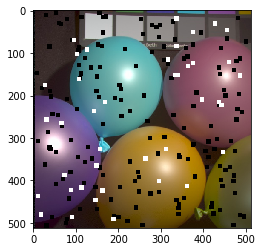

In [7]:
from main import visualize_selected_patches
import matplotlib.pyplot as plt

selected_patches = visualize_selected_patches(rgb_img.copy(), train_patches, patches_size, color=0)
selected_patches = visualize_selected_patches(selected_patches, test_patches, patches_size, color=255)
plt.imshow(selected_patches)

Finally we train the regresson model.

In [8]:
from models.regression import Regression

regresstion = Regression(train_ls, train_hs)
regresstion.train()
predictions = regresstion.model.predict(test_ls)

The RMSE and Delta 2 200 scores are as follow.

In [9]:
from main import get_rmse, get_delta_e_2000

train_predictions = regresstion.model.predict(train_ls)
print('For train data, rmse is: ', get_rmse(train_hs, train_predictions), ', delta e is: ', get_delta_e_2000(train_hs, train_predictions))

print('For test data, rmse is: ', get_rmse(test_hs, predictions), ', delta e is: ', get_delta_e_2000(test_hs, predictions))

For train data, rmse is:  0.05295146954000687 , delta e is:  11.260145267920077
For test data, rmse is:  0.04218852508261359 , delta e is:  11.14435717541418


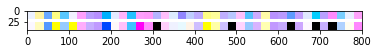

In [10]:
from main import visualize_results

result = visualize_results(test_hs, predictions)
plt.imshow(result)

In [11]:
from main import run
import seaborn as sns
import numpy as np

def multi_run(method='rgb', patches_size=PATCHES_SIZE):
    rmses = []
    delta_es = []
    for i in range(100):
        rmse, delta_e = run(method=method, patches_size=patches_size)
        rmses.append(rmse)
        delta_es.append(delta_e)
    return rmses, delta_es
        
def get_results(patches_size=PATCHES_SIZE):
    rgb_rmses, rgb_delta_es = multi_run(method='rgb', patches_size=patches_size)
    xyz_rmses, xyz_delta_es = multi_run(method='xyz', patches_size=patches_size)
    lab_rmses, lab_delta_es = multi_run(method='lab', patches_size=patches_size)
    return rgb_rmses, rgb_delta_es, xyz_rmses, xyz_delta_es, lab_rmses, lab_delta_es
    

rgb_rmses, rgb_delta_es, xyz_rmses, xyz_delta_es, lab_rmses, lab_delta_es = get_results()

In [12]:
print('rgb rmse mean is: ', np.mean(rgb_rmses), '\nrgb delta e mean is: ', np.mean(rgb_delta_es))

rgb rmse mean is:  0.050262157508502325 
rgb delta e mean is:  10.698690630251983


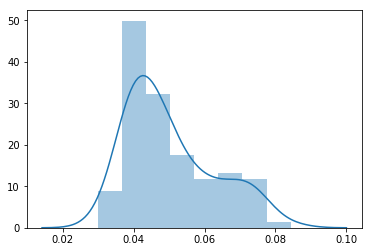

In [13]:
sns.distplot(rgb_rmses)

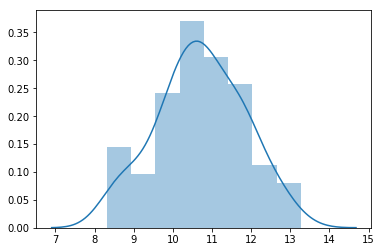

In [14]:
sns.distplot(rgb_delta_es)


If instead of RGB image we use XYZ image, the result would be as follows: 

In [15]:
print('xyz rmse mean is: ', np.mean(xyz_rmses), '\nxyz delta e mean is: ', np.mean(xyz_delta_es))

xyz rmse mean is:  0.013873938031357147 
xyz delta e mean is:  2.6513623277817664


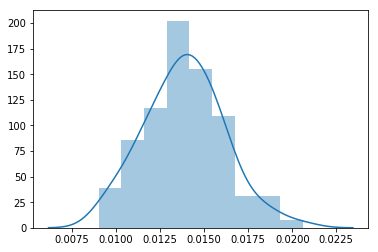

In [16]:
sns.distplot(xyz_rmses)

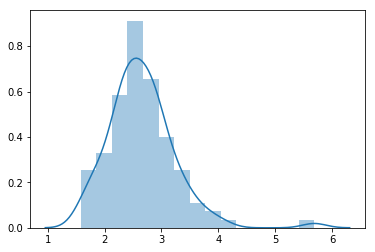

In [17]:
sns.distplot(xyz_delta_es)

Also, if instead of RGB image we use LAB image, the result would be as follows:

In [18]:
print('lab rmse mean is: ', np.mean(lab_rmses), '\nlab delta e mean is: ', np.mean(lab_delta_es))

lab rmse mean is:  0.06031684805421961 
lab delta e mean is:  12.848997451610925


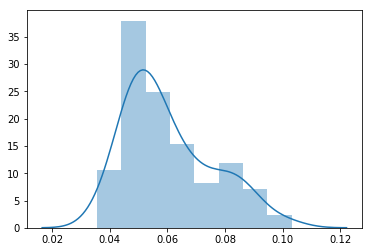

In [19]:
sns.distplot(lab_rmses)

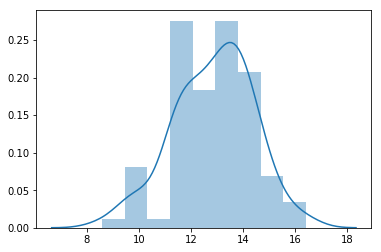

In [20]:
sns.distplot(lab_delta_es)

In [21]:
print('rgb mean rmses: ', np.mean(rgb_rmses), '\nxyz mean rmses: ', np.mean(xyz_rmses), 
      '\nlab mean rmses: ', np.mean(lab_rmses))

rgb mean rmses:  0.050262157508502325 
xyz mean rmses:  0.013873938031357147 
lab mean rmses:  0.06031684805421961


In [22]:
print('rgb mean delta e: ', np.mean(rgb_delta_es), '\nxyz mean delta e: ', np.mean(xyz_delta_es), 
      '\nlab mean delta e: ', np.mean(lab_delta_es))

rgb mean delta e:  10.698690630251983 
xyz mean delta e:  2.6513623277817664 
lab mean delta e:  12.848997451610925


So using XYZ images for training has the best error.

xyz rmse is:  0.020804313894678836 , delta e is:  2.0841737301028735


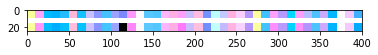

In [23]:
rmse, delta_e = run(patches_num, method='xyz',  patches_size=PATCHES_SIZE, visualize=True)
print('xyz rmse is: ', rmse, ', delta e is: ', delta_e)

rgb rmse is:  0.0843063492645329 , delta e is:  12.184175320081298


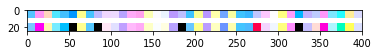

In [24]:
rmse, delta_e = run(patches_num, method='rgb',  patches_size=PATCHES_SIZE, visualize=True)
print('rgb rmse is: ', rmse, ', delta e is: ', delta_e)

lab rmse is:  0.04987057334451627 , delta e is:  12.761479304342302


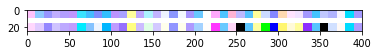

In [25]:
rmse, delta_e = run(patches_num, method='lab',  patches_size=PATCHES_SIZE, visualize=True)
print('lab rmse is: ', rmse, ', delta e is: ', delta_e)

Now let's try the model for patches_size=1.

In [26]:
rgb_rmses_1, rgb_delta_es_1, xyz_rmses_1, xyz_delta_es_1, lab_rmses_1, lab_delta_es_1 = get_results(patches_size=1)

In [27]:
print('results for patch_size = 1 \n')

print('rgb mean rmses: ', np.mean(rgb_rmses_1),
      '\nxyz mean rmses: ', np.mean(xyz_rmses_1),
      '\nlab mean rmses: ', np.mean(lab_rmses_1),
     )

print()
print('rgb mean delta e: ', np.mean(rgb_delta_es_1), 
      '\nxyz mean delta e: ', np.mean(xyz_delta_es_1),
      '\nlab mean delta e: ', np.mean(lab_delta_es_1), 
     )



results for patch_size = 1 

rgb mean rmses:  0.05349598082104874 
xyz mean rmses:  0.015156610737283336 
lab mean rmses:  0.06350780678247041

rgb mean delta e:  10.88499842378014 
xyz mean delta e:  3.0412340571062177 
lab mean delta e:  12.968659671403787


In [28]:
print('compare effect of patche size\n')

print('rgb mean rmses: ', np.mean(rgb_rmses), ',', np.mean(rgb_rmses_1), ': rgb mean rmses patch size 1', 
      '\nxyz mean rmses: ', np.mean(xyz_rmses), ',', np.mean(xyz_rmses_1), ': xyz mean rmses patch size 1', 
      '\nlab mean rmses: ', np.mean(lab_rmses), ',', np.mean(lab_rmses_1), ': lab mean rmses patch size 1'
     )

print()
print('rgb mean delta_e: ', np.mean(rgb_delta_es), ',', np.mean(rgb_delta_es_1), ': rgb mean delta_e patch size 1',  
      '\nxyz mean delta_e: ', np.mean(xyz_delta_es), ',', np.mean(xyz_delta_es_1), ': xyz mean delta_e patch size 1',
      '\nlab mean delta_e: ', np.mean(lab_delta_es), ',', np.mean(lab_delta_es_1), ': lab mean delta_e patch size 1'
     )

compare effect of patche size

rgb mean rmses:  0.050262157508502325 , 0.05349598082104874 : rgb mean rmses patch size 1 
xyz mean rmses:  0.013873938031357147 , 0.015156610737283336 : xyz mean rmses patch size 1 
lab mean rmses:  0.06031684805421961 , 0.06350780678247041 : lab mean rmses patch size 1

rgb mean delta_e:  10.698690630251983 , 10.88499842378014 : rgb mean delta_e patch size 1 
xyz mean delta_e:  2.6513623277817664 , 3.0412340571062177 : xyz mean delta_e patch size 1 
lab mean delta_e:  12.848997451610925 , 12.968659671403787 : lab mean delta_e patch size 1


As you see the results of patch size = 1 isn't much different from patch size = PATCH_SIZE.